In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import torch
import zarr
import h5py
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.ndimage
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from omegaconf import OmegaConf
from scipy.ndimage import gaussian_filter
from torch.utils.data import DataLoader

from brainage.model.model3d import AgeModel3DVolume
from brainage.dataset.grid3d import GridPatchSampler, DataReaderHDF5

In [2]:
data_dir = Path('/mnt/qdata/raheppt1/data/brainage/nako/')
data_path = data_dir/'interim/t1_pp_10_cropped.h5'
maps_path = data_dir/'processed/patchwise/maps.zarr'

In [3]:
pred_patch = pd.read_feather(data_dir/'processed/patchwise/predictions_regional.feather')
pred_volume = pd.read_feather(data_dir/'processed/volume/predictions.feather')

### Single subject

In [4]:
with h5py.File(data_path, 'r') as hf:
    with zarr.open(str(maps_path)) as zf:
        keys = list(zf['agemaps'])
        key = keys[0]
        agemaps = zf['agemaps'][key][:]
        mri = hf['image'][key][:]
a_c = pred_volume[pred_volume['key']==key]['y'].item()
a_p = pred_volume[pred_volume['key']==key]['y_hat0'].item()


In [5]:
pred_volume[pred_volume['key']==key]

,key,y,y_hat0,y_hat1
0,100000,52.0,49.465534,0.885896


chronological age 52.00 49.47


Text(0.5, 1.0, 'regional age')

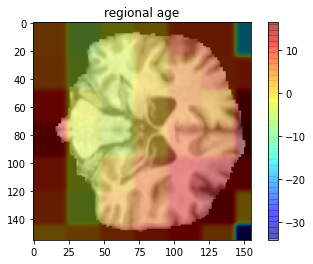

In [6]:
sl = 80
sigma = 1.5
print(f'chronological age {a_c:.2f} {a_p:.2f}')
plt.imshow(mri[:,sl,:].astype(np.float32), cmap='gray')
smooth_img = np.copy(agemaps[0][:,sl,:])
smooth_img = gaussian_filter(smooth_img - a_p, sigma=sigma)
plt.imshow(smooth_img, cmap='jet', alpha=0.4)
plt.colorbar()
plt.title('regional age')

Text(0.5, 1.0, 'regional uncertainty')

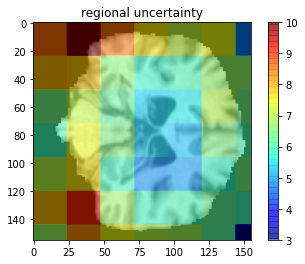

In [7]:
sl = 80
plt.imshow(mri[:,sl,:].astype(np.float32), cmap='gray')
plt.imshow(np.exp(agemaps[1,:,sl,:]),vmin=3, vmax=10, cmap='jet', alpha=0.5)
plt.colorbar()
plt.title('regional uncertainty')

### Average

In [111]:
agemaps_mean = np.zeros([155, 185, 155])
img_mean = np.zeros([155, 185, 155])
with h5py.File(data_path, 'r') as hf:
    with zarr.open(str(maps_path)) as zf:
        keys = list(zf['agemaps'])
        for key in tqdm(keys):
            a_c = pred_volume[pred_volume['key']==key]['y'].item()
            a_p = pred_volume[pred_volume['key']==key]['y_hat0'].item()     
            agemaps = np.abs(zf['agemaps'][key][0, :] - a_c)
            img = hf['image'][key][:]
            img_mean = img_mean + img
            agemaps_mean = agemaps_mean + agemaps
    img_mean = img_mean/len(keys)
    agemaps_mean = agemaps_mean/len(keys)

In [10]:
mni_brain = nib.load('/home/raheppt1/tools/FSL/data/standard/MNI152_T1_1mm_brain.nii.gz')
affine = mni_brain.affine
nib.save(nib.Nifti1Image(agemaps_mean, affine), str(data_dir/'processed/patchwise/export/map_mae_average.nii.gz'))


NameError: name 'agemaps_mean' is not defined

In [12]:
# general plots parameters
mpl.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1.5

In [18]:
mni_brain = nib.load('/home/raheppt1/tools/FSL/data/standard/MNI152_T1_1mm_brain.nii.gz')
affine = mni_brain.affine
mni_brain = mni_brain.get_fdata()[(slice(15,170), slice(15,200), slice(0,155))]
agemaps_mean = nib.load(data_dir/'processed/patchwise/export/map_mae_average.nii.gz')
agemaps_mean = agemaps_mean.get_fdata()
map_sigma = nib.load(data_dir/'processed/patchwise/export/map_sigma_average.nii.gz')
map_sigma = map_sigma.get_fdata()

In [19]:
map_diff.shape

(155, 185, 155)

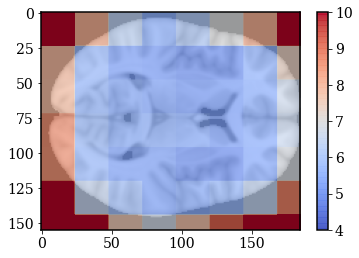

In [20]:
sl = 80
sigma = 15.0
plt.imshow(mni_brain[:,:,sl], cmap='gray')
plt.imshow(agemaps_mean[:,:,sl], cmap='coolwarm', alpha=0.7, vmin=4, vmax=10.0)
plt.colorbar()

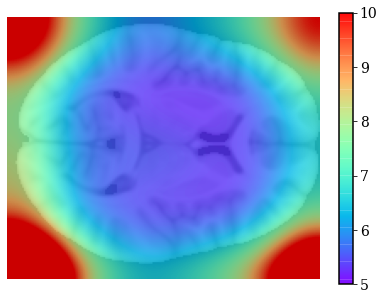

In [42]:
sl = 80
sigma = 15.0
fig = plt.figure(figsize=(7,5))
plt.axis('off')
plt.imshow(mni_brain[:,:,sl], cmap='gray')
tmp = np.copy(agemaps_mean)
plt.imshow(gaussian_filter(tmp, sigma=sigma)[:,:,sl], cmap='rainbow', alpha=0.8, vmin=5.0, vmax=10.0)
plt.colorbar()
plt.savefig('Figure5a.pdf', dpi=600, transparent=False, bbox_inches='tight')

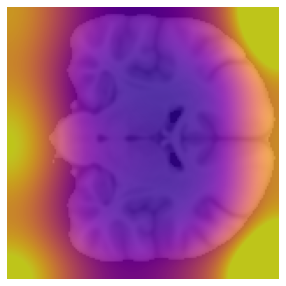

In [80]:
sl = 92
sigma = 15.0
fig = plt.figure(figsize=(7,5))
plt.axis('off')
plt.imshow(mni_brain[:,sl,:], cmap='gray')
tmp = np.copy(agemaps_mean)
plt.imshow(gaussian_filter(tmp, sigma=sigma)[:,sl,:], cmap='plasma', alpha=0.8, vmin=5.0, vmax=10.0)
plt.savefig('Figure5b.pdf', dpi=600, transparent=False, bbox_inches='tight')

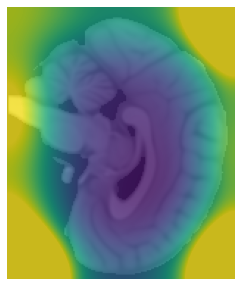

In [83]:
sl = 77
sigma = 15.0
fig = plt.figure(figsize=(7,5))
plt.axis('off')
plt.imshow(mni_brain[sl,:,:], cmap='gray')
tmp = np.copy(agemaps_mean)
plt.imshow(gaussian_filter(tmp, sigma=sigma)[sl,:,:], cmap='viridis', alpha=0.8, vmin=5.0, vmax=10.0)
plt.savefig('Figure5c.pdf', dpi=600, transparent=False, bbox_inches='tight')

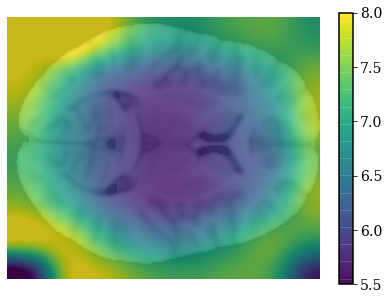

In [82]:
sl = 80
sigma = 10.0
fig = plt.figure(figsize=(7,5))
plt.axis('off')
plt.imshow(mni_brain[:,:,sl], cmap='gray')
tmp = np.copy(np.exp(map_sigma))
plt.imshow(gaussian_filter(tmp, sigma=sigma)[:,:,sl], cmap='viridis', alpha=0.8,vmin=5.5, vmax=8.0)
plt.colorbar()
plt.savefig('Figure5d.pdf', dpi=600, transparent=False, bbox_inches='tight')

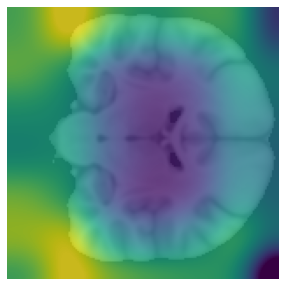

In [84]:
sl = 92
sigma = 10.0
fig = plt.figure(figsize=(7,5))
plt.axis('off')
plt.imshow(mni_brain[:,sl,:], cmap='gray')
tmp = np.copy(np.exp(map_sigma))
plt.imshow(gaussian_filter(tmp, sigma=sigma)[:,sl,:], cmap='viridis', alpha=0.8, vmin=5.5, vmax=8.0)
plt.savefig('Figure5e.pdf', dpi=600, transparent=False, bbox_inches='tight')

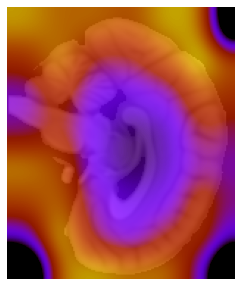

In [75]:
sl = 77
sigma = 10.0
fig = plt.figure(figsize=(7,5))
plt.axis('off')
plt.imshow(mni_brain[sl,:,:], cmap='gray')
tmp = np.copy(np.exp(map_sigma))
plt.imshow(gaussian_filter(tmp, sigma=sigma)[sl,:,:], cmap='gnuplot', alpha=0.8, vmin=5.5, vmax=8.0)
plt.savefig('Figure5f.pdf', dpi=600, transparent=False, bbox_inches='tight')